# Problem Statement

#### Cassava leaf disease classification is the process of identifying and categorizing the various diseases that can affect the leaves of the cassava plant. This is important for effective disease management and the preservation of cassava yields. The diseases are typically classified based on symptoms, causative agents (such as fungi, viruses, or bacteria), and mode of transmission. Examples of common cassava leaf diseases include cassava mosaic disease, cassava bacterial blight, and cassava brown streak disease. ####

#### This project uses artificial intelligence to detect and classify cassava leaf diseases. Problem statement and datasets can be found here: https://www.kaggle.com/c/cassava-leaf-disease-classification ####

#### For this task, I have used exploratory data analysis and transfer learning with a pretrained model EfficientNetB3. ####

In [2]:
import numpy as np
import pandas as pd
import os,json
from tqdm.notebook import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB3, EfficientNetB4
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Layer, Dense, Flatten, Dropout
from tensorflow.keras.layers import  GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.losses import Loss

#for graphs and images
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

In [6]:
# directory path
dir_path = '/kaggle/input/cassava-leaf-disease-classification/'

# Read the CSV file into a pandas DataFrame
train_df = pd.read_csv(dir_path + 'train.csv')

# Display the train set
display(train_df)

# Display information about the train set
train_df.info()

image_id  label
0      1000015157.jpg      0
1      1000201771.jpg      3
2       100042118.jpg      1
3      1000723321.jpg      1
4      1000812911.jpg      3
...               ...    ...
21392   999068805.jpg      3
21393   999329392.jpg      3
21394   999474432.jpg      1
21395   999616605.jpg      4
21396   999998473.jpg      4

[21397 rows x 2 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 334.5+ KB


classes =  {
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
} 

label  class_name                         
0      Cassava Bacterial Blight (CBB)          1087
1      Cassava Brown Streak Disease (CBSD)     2189
2      Cassava Green Mottle (CGM)              2386
3      Cassava Mosaic Disease (CMD)           13158
4      Healthy                                 2577
Name: class_name, dtype: int64 



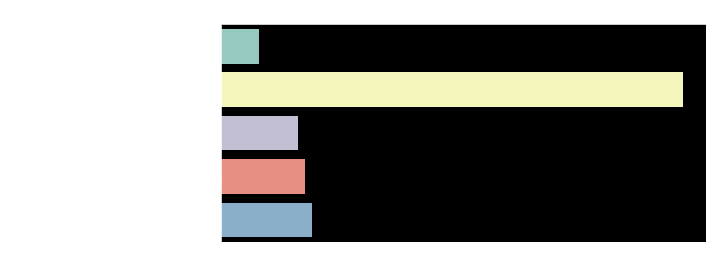

In [7]:
# Load and print disease classes 
with open(dir_path + "label_num_to_disease_map.json") as f:
    classes = json.load(f)     
print('classes = ', json.dumps(classes, indent=4), '\n')  

# Map labels to their classes   
train_df['class_name'] = train_df['label'].map(lambda x: classes[str(x)])

# Count number of samples in each class
label_count = train_df.groupby(['label','class_name'])['class_name'].count()
print(label_count, '\n')

# Create a countplot for number of samples in each class
plt.figure(figsize=(10,4))
plt.style.use('dark_background')
ax = sns.countplot(data=train_df, y='class_name')
ax.set_title('Number of samples in each class', size=15)
plt.tight_layout()
plt.show()

#### Let's visualize a few pictures from each class. ####

In [8]:
train_images = dir_path + 'train_images/' 

# Create a function to read and display images
def show_images(class_label):
    one_class_df = train_df[train_df.label==class_label].reset_index(drop=True)
    plt.figure(figsize=(14,14))
    for i in range(10):
        img = train_images + one_class_df.loc[i,'image_id']
        img = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
        plt.subplot(5,5,i+1)
        plt.imshow(img)
        plt.suptitle(one_class_df.loc[i,'class_name'], y=1.04, fontsize=18)
        plt.axis("off")
    plt.tight_layout()

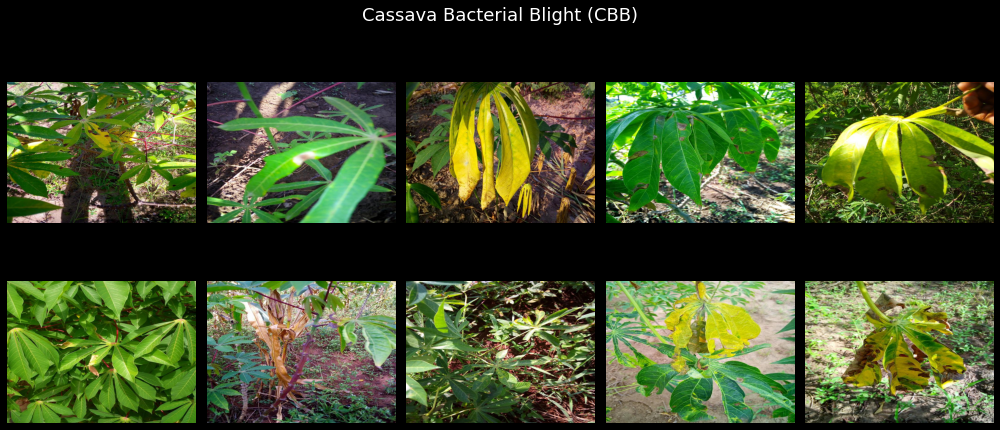

In [5]:
# Display 10 images from cassava bacterial blight disease
show_images(0)

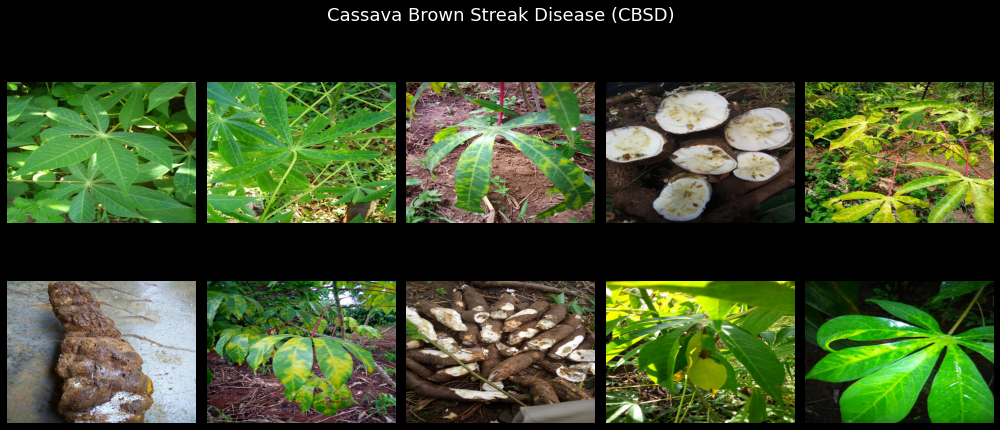

In [7]:
# Display 10 images from cassava brown streak disease
show_images(1)

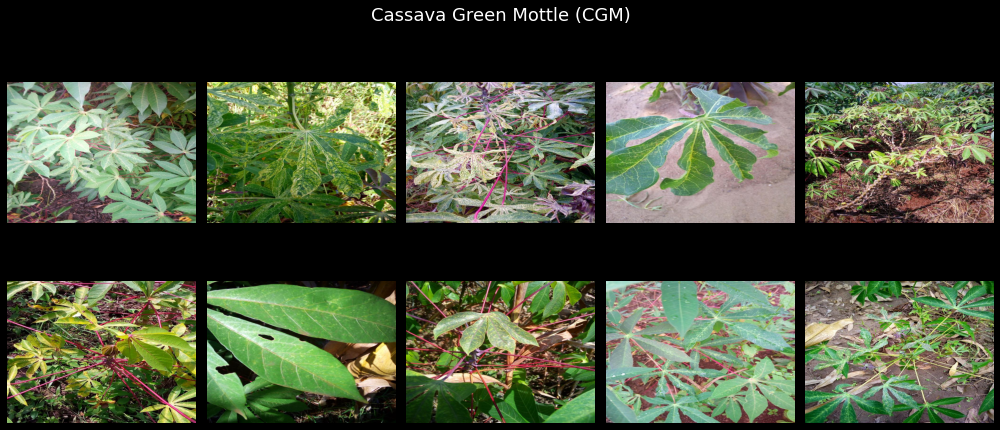

In [8]:
# Display 10 images from cassava green mottle disease
show_images(2)

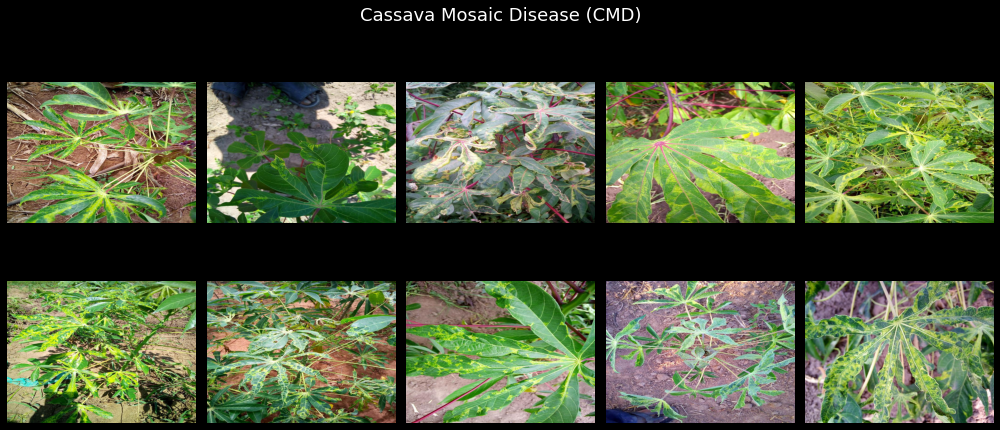

In [9]:
# Display 10 images from cassava mosaic disease
show_images(3)

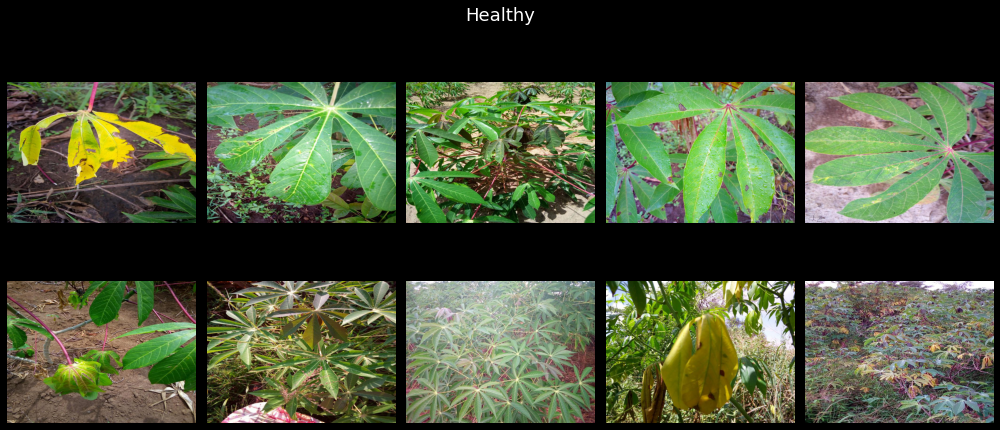

In [10]:
# Display 10 images from healthy cassava leaves
show_images(4)

In [9]:
sample_image = train_images + train_df.loc[0,'image_id']
print('image dimensions = ',np.shape(cv2.imread(sample_image)))

image dimensions =  (600, 800, 3)


#### Some images in some classes appear to look significantly different from the rest of the class. This could be a sign of outliers. We can detect the outliers by using the statistics of the images in each class. ####

#### First, the statistical quantities (mean and standard deviation) of each image in each class are added to a dictionary. ####

In [10]:
image_stats = {'Cassava Bacterial Blight (CBB)':[],
               'Cassava Brown Streak Disease (CBSD)':[],
               'Cassava Green Mottle (CGM)':[],
               'Cassava Mosaic Disease (CMD)':[],
               'Healthy':[]
              }

for class_name in tqdm(train_df.class_name.unique()):
    new_df = train_df[train_df.class_name == class_name]
    for idx in tqdm(new_df.index):
        img = train_images + new_df.loc[idx,'image_id']
        
        # Read and normalize the image
        img = cv2.imread(img)
        img = cv2.normalize(img, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        
        # Store statistical quantities of the image and its index
        image_stats[class_name].append([np.mean(img), np.std(img), idx])

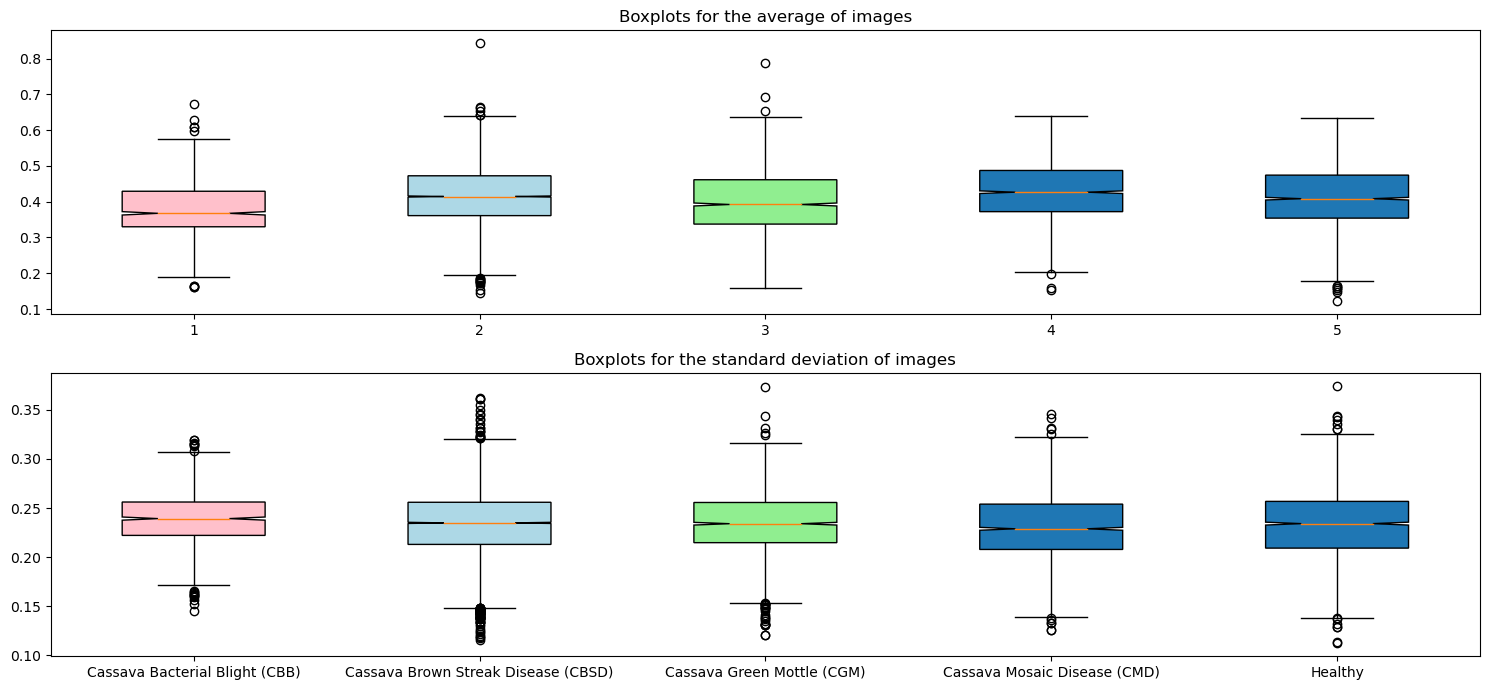

In [19]:
mean_data, std_data = [], []
for class_name in tqdm(train_df.class_name.unique()):
    n = len(image_stats[class_name])
    mean_data.append([image_stats[class_name][i][0] for i in range(n)])
    std_data.append([image_stats[class_name][i][1] for i in range(n)])

# Create the boxplots
fig, ax = plt.subplots(2, figsize=(15,7))
bp1 = ax[0].boxplot(mean_data, patch_artist=True, notch=True)
ax[0].set_title('Boxplots for the average of images')
bp2 = ax[1].boxplot(std_data, patch_artist=True, notch=True, labels=list(classes.values()))
ax[1].set_title('Boxplots for the standard deviation of images')


# fill with colors
colors = ['pink', 'lightblue', 'lightgreen']
for bp in (bp1, bp2):
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

plt.style.use('default')
plt.tight_layout()
plt.show()

#### From the boxplots for the mean and standard deviation, we can see the presence of more extreme samples. ####

In [67]:
# Create the inter-quartile function
def IQR(X,p1,p2):
    q1, q2 = np.percentile(X,[p1,p2])
    iqr = q2 - q1
    lower_bound  = q1 - (1.5 * iqr) 
    upper_bound = q2 + (1.5 * iqr)
    out_index = np.where((X > upper_bound) | (X < lower_bound))[0]
    return out_index

# Find the outliers in each class
def detect_outliers(train_df,p1,p2):
    outliers = []
    for class_name in train_df.class_name.unique():
        n = len(image_stats[class_name])
        mean_data = [image_stats[class_name][i][0] for i in range(n)]
        std_data = [image_stats[class_name][i][1] for i in range(n)]
        outlier_index = np.append(IQR(mean_data,p1,p2), IQR(std_data,p1,p2))
        for idx in list(outlier_index):
            # Outlier indexes in dataframe
            index_outlier_df = image_stats[class_name][idx][2]
            outliers.append(index_outlier_df)
    return outliers

#### In the above functions, we can modify the inter-quartile range to detect the outliers. Fo example, setting the lower and upper percentiles to $20$ and $85$ respectively, we obtain the following images whose statistical quantities fall outside of the range in the IQR function. ####

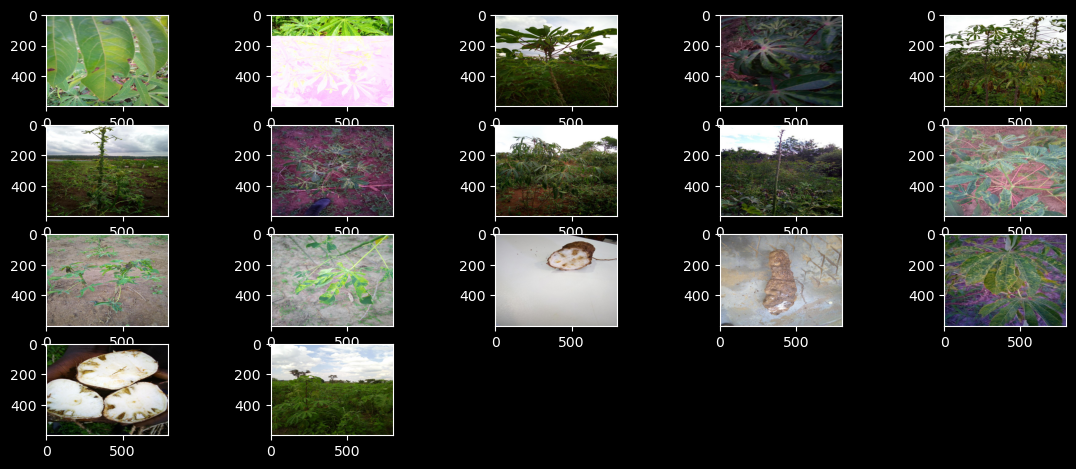

In [99]:
outliers = detect_outliers(train_df, 20, 85)

plt.figure(figsize=(14,14))
plt.style.use('dark_background')
for i, idx in enumerate(outliers):
    outlier_img = train_images + train_df.loc[idx,'image_id']
    outlier_img = cv2.cvtColor(cv2.imread(outlier_img), cv2.COLOR_BGR2RGB)
    plt.subplot(10,5,i+1)
    plt.imshow(outlier_img)
plt.show()

#### And changing the percentiles to $20$ and $90$ returns the more extreme samples which are shown below. ####

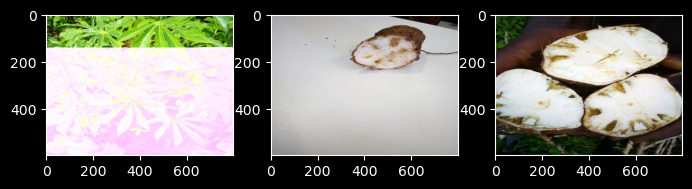

In [147]:
outliers = detect_outliers(train_df, 20, 90)

plt.figure(figsize=(14,14))
plt.style.use('dark_background')
for i, idx in enumerate(outliers):
    outlier_img = train_images + train_df.loc[idx,'image_id']
    outlier_img = cv2.cvtColor(cv2.imread(outlier_img), cv2.COLOR_BGR2RGB)
    plt.subplot(5,5,i+1)
    plt.imshow(outlier_img)
plt.show()

In [148]:
# Remove the outliers from dataframe
train_df.drop(index=outliers, inplace=True)
train_df.reset_index(inplace=True)

#### The technique of developing new training examples from the ones that already exist is known as image augmentation. We gently alter the original image to create a new sample. For instance, you may chop a portion from the original image, produce a new image by mirroring the original one, or make the new image a little brighter. ####

#### We can import and augment the data using ImageDataGenerator. ####

In [153]:
# Drop the last column: class_name
train_df.pop('class_name')

# labels
y = train_df['labels']

# Convert labels to strings
train_df.label = train_df.label.astype('str')

IMAGE_SIZE = 300
BATCH_SIZE = 16

# Split the dataset and keep the proportion of labels through the training and validation sets
xtrain, xvalid, ytrain, yvalid = train_test_split(train_df, y, test_size = 0.1, random_state = 42, stratify=y)


datagen_train = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 45,
                    shear_range = 0.1,
                    zoom_range = 0.2,
                    width_shift_range = 0.,
                    height_shift_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')

datagen_validation = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    )

train_generator = datagen_train.flow_from_dataframe(xtrain,
                             directory = train_images,
                             target_size = (IMAGE_SIZE,IMAGE_SIZE),
                             x_col = 'image_id',
                             y_col = 'label',
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             batch_size = BATCH_SIZE,
                             shuffle = True)

validation_generator = datagen_validation.flow_from_dataframe(xvalid,
                             directory = train_images,
                             target_size = (IMAGE_SIZE,IMAGE_SIZE),
                             x_col = 'image_id',
                             y_col = 'label',
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             batch_size = BATCH_SIZE,
                             shuffle = True)


Found 19254 validated image filenames belonging to 5 classes.
Found 2140 validated image filenames belonging to 5 classes.


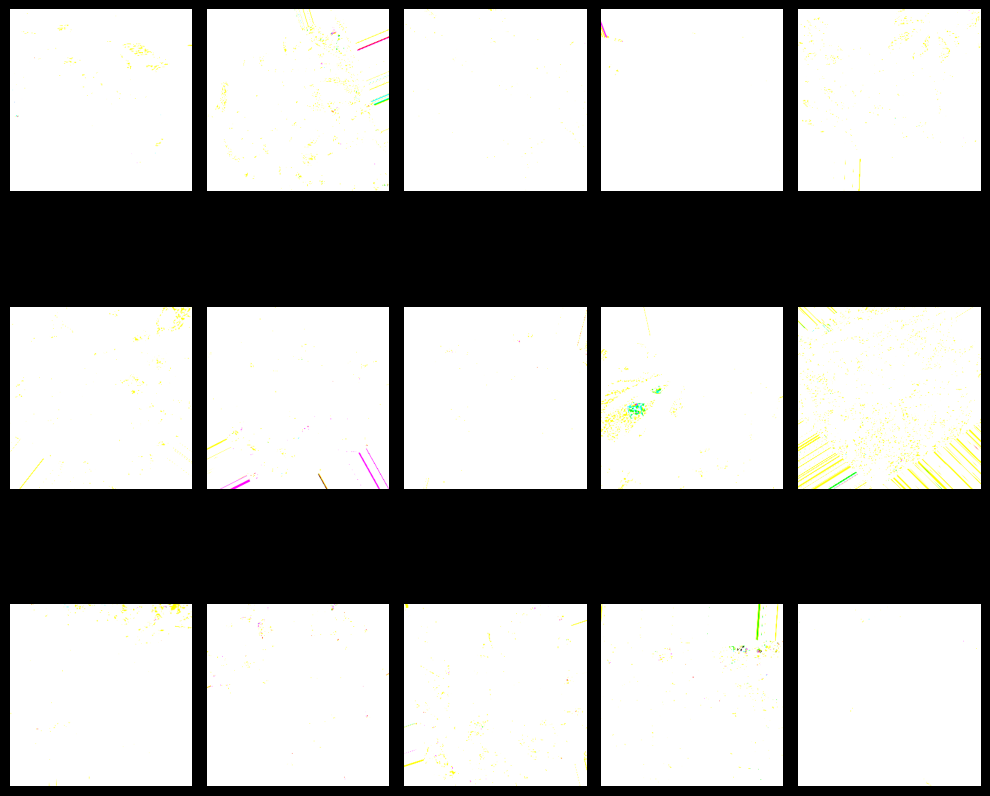

In [154]:
images = [train_generator[0][0][i] for i in range(16)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))

axes = axes.flatten()

for img, ax in zip(images, axes):
    ax.imshow(img.reshape(IMAGE_SIZE, IMAGE_SIZE, 3))
    ax.axis('off')

plt.tight_layout()
plt.show()

For training, I have used a pre-trained EfficientNetB3 model. The weights are the 'imagenet' weights. These weights are trained for object classification. We use the already-trained initial layers which detects lower-level features like edges, etc. We then replace the top layers with our own dense layers to recognize higher level features and this is the reason that we set the include_top parameter of the EfficientNet to False.

This method is called Transfer Learning.

In [155]:
class SimpleQuadraticDense(Layer):

    def __init__(self, units, activation):
        super().__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        a_init = tf.random_normal_initializer()
        self.a = tf.Variable(name='kernel', initial_value=a_init(shape=(input_shape[-1], self.units)),
                          trainable=True)
      
        b_init = tf.random_normal_initializer()
        self.b = tf.Variable(name='kernel', initial_value=b_init(shape=(input_shape[-1], self.units)),
                          trainable=True)
      
        c_init = tf.zeros_initializer()
        self.c = tf.Variable(name='bias', initial_value=c_init(shape=(self.units,)),
                           trainable=True)
      
    def call(self, inputs):
        return self.activation(tf.matmul(inputs**2, self.a) + tf.matmul(inputs, self.b) + self.c)
      

In [158]:
def build_model(num_classes):
    
    model = Sequential()
    EfficientNet = tf.keras.applications.EfficientNetB3(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
                                                        include_top = False,
                                                        weights = 'imagenet')
    model.add(EfficientNet)
    model.add(GlobalAveragePooling2D())
    #model.add(SimpleQuadraticDense(units = 128, activation='relu'))
    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation = 'softmax'))
    
    optimizer = tf.keras.optimizers.Adam(lr=1e-3)
    model.compile(optimizer=optimizer,
                  loss="categorical_crossentropy",
                  metrics=["categorical_accuracy"])
    
    return model

43941888/43941136 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 10, 10, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               786944    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 11,573,044
Trainable params: 11,485,741
Non-trainable params: 87,303
_________________________________________________________________


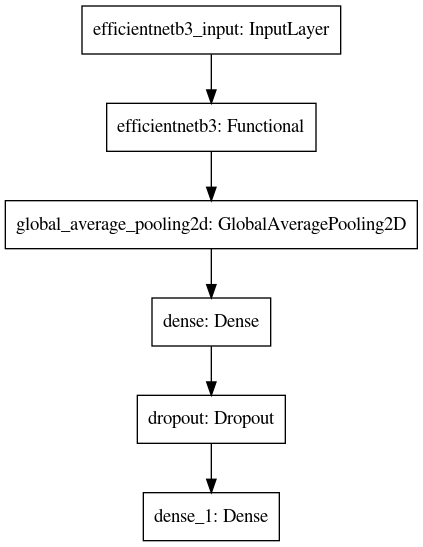

In [159]:
model = build_model(num_classes=5)
model.summary()
tf.keras.utils.plot_model(model)

In [160]:
model = build_model(num_classes=5)
    
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                            patience = 4)

checkpoint = tf.keras.callbacks.ModelCheckpoint("EB3_weights.h5",
                                                save_weights_only = True,
                                                monitor = 'val_accuracy', 
                                                mode ='max')   
    

EPOCHS = 10 

history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // BATCH_SIZE,
    epochs = EPOCHS,
    callbacks = [callback, checkpoint],
    verbose=1)

model.save('MyModel.h5')
model.save('./MyModel_tf',save_format='tf')

Epoch 1/10
1203/1203 [==============================] - 782s 650ms/step - loss: 0.6868 - categorical_accuracy: 0.7605 - val_loss: 0.5638 - val_categorical_accuracy: 0.8139
Epoch 2/10
1203/1203 [==============================] - 774s 643ms/step - loss: 0.5457 - categorical_accuracy: 0.8148 - val_loss: 0.7310 - val_categorical_accuracy: 0.7425
Epoch 3/10
1203/1203 [==============================] - 776s 645ms/step - loss: 0.4992 - categorical_accuracy: 0.8298 - val_loss: 0.4559 - val_categorical_accuracy: 0.8524
Epoch 4/10
1203/1203 [==============================] - 767s 638ms/step - loss: 0.4806 - categorical_accuracy: 0.8357 - val_loss: 0.5124 - val_categorical_accuracy: 0.8388
Epoch 5/10
1203/1203 [==============================] - 764s 635ms/step - loss: 0.4634 - categorical_accuracy: 0.8436 - val_loss: 0.4547 - val_categorical_accuracy: 0.8487
Epoch 6/10
1203/1203 [==============================] - 771s 641ms/step - loss: 0.4484 - categorical_accuracy: 0.8463 - val_loss: 0.4727 - v

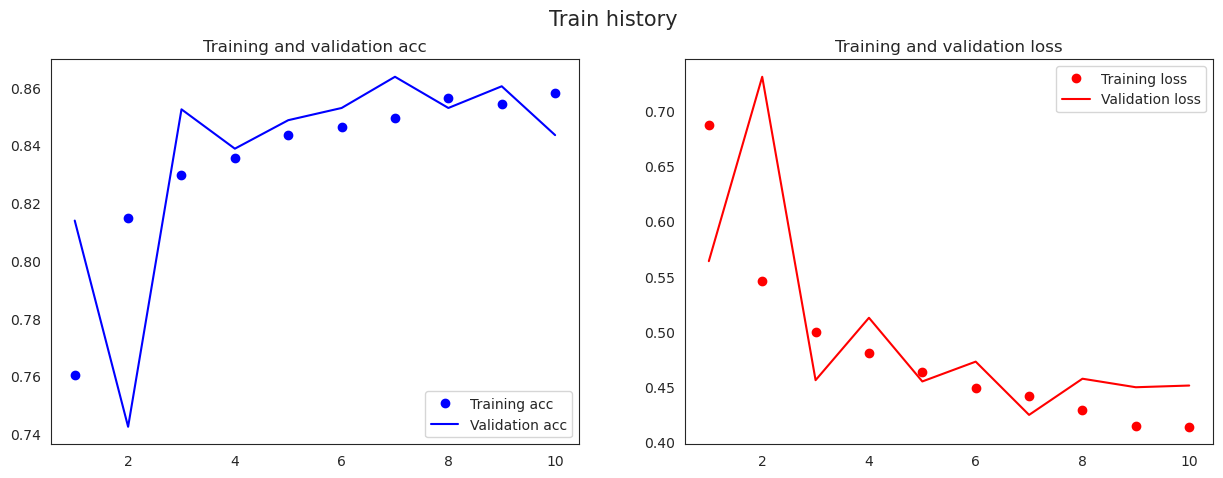

In [169]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, acc, "bo", label = "Training acc")
ax1.plot(epochs, val_acc, "b", label = "Validation acc")
ax1.set_title("Training and validation acc")
ax1.legend()

ax2.plot(epochs, loss, "bo", label = "Training loss", color = 'red')
ax2.plot(epochs, val_loss, "b", label = "Validation loss", color = 'red')
ax2.set_title("Training and validation loss")
ax2.legend()

plt.show()

In [ ]:
model = build_model(num_classes=5)
model.load_weights('EB3_weights.h5')
model.evaluate(validation_generator)

#### Finally I make predictions on the test set using the saved model. ####

In [166]:
from PIL import Image

test_dir = dir_path + 'test_images/'
test_images = os.listdir(test_dir)
predictions = []

for image in test_images:
    img = test_dir + image
    img = Image.open(img)
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
    img = np.expand_dims(img, axis=0)
    predictions.extend(model.predict(img).argmax(axis=1))
    
submission = pd.DataFrame({'image_id': test_images, 'label': predictions})
submission.to_csv('submission.csv', index = False)